In [2]:
pip install textblob

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 626.3/626.3 kB 16.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 41.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 782.7/782.7 kB 34.3 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import numpy as np
from textblob import TextBlob
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/jupyter/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /home/jupyter/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [4]:
from google.cloud import bigquery

# Initialize the BigQuery client
client = bigquery.Client()

# Replace with your project ID and BigQuery table details
project_id = "airy-box-431604-j9"
dataset_id = "amazon_reviews"
table_id = "clean_data"

# Construct the full table ID
table_ref = f"{project_id}.{dataset_id}.{table_id}"

# Query the table
query = f"SELECT * FROM `{table_ref}`"

# Execute the query and convert it to a pandas DataFrame
query_job = client.query(query)
df = query_job.to_dataframe()

# Display the DataFrame
df.head()

,rating,review_hash,review_text,title,helpful_votes
0,1,[1218d212ed5597167f5cb39a029afaa8],Poor product,Does not power on,0
1,1,[88c3f69d90a19e4b6cfed2b0b9cdfbea],Received only charging caseEarbuds missing fro...,Missing parts,0
2,1,[5efc78b71a890ae3855463ed85610ff7],Very bed product after 3 month left side earbu...,pt.arvinddabral@gmail.com,0
3,1,[5d5ff017a6a051fe6c231bf92717343d],sound is decent but battery dies pretty quick ...,NOT GOOD AT ALL,0
4,1,[443719dacd2e9a9b8b9289aafbafb973],I regret buying these earbuds. Even boat and r...,Very cheap earbuds from JBL,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1301 entries, 0 to 1300
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   rating         1301 non-null   Int64 
 1   review_hash    1301 non-null   object
 2   review_text    1301 non-null   object
 3   title          1301 non-null   object
 4   helpful_votes  1301 non-null   object
dtypes: Int64(1), object(4)
memory usage: 52.2+ KB


In [6]:
df['helpful_votes'] = df['helpful_votes'].astype(int)

In [7]:
df.columns

Index(['rating', 'review_hash', 'review_text', 'title', 'helpful_votes'], dtype='object')

In [8]:
df.drop(columns='review_hash', inplace=True)

## Feature Engineering

In [10]:
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/jupyter/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [11]:
# Feature 1: Review Length
df['review_length'] = df['review_text'].apply(len)
df['review_word_count'] = df['review_text'].apply(lambda x: len(word_tokenize(x)))

In [12]:
# Feature 2: Sentiment Score
df['review_sentiment'] = df['review_text'].apply(lambda x: TextBlob(x).sentiment.polarity)
df['review_subjectivity'] = df['review_text'].apply(lambda x: TextBlob(x).sentiment.subjectivity)

In [13]:
# Feature 3: Readability Score (Flesch-Kincaid Score)
def flesch_kincaid(text):
    words = word_tokenize(text)
    sentences = len(re.split(r'[.!?]', text))
    syllables = sum([len([s for s in word if s in 'aeiou']) for word in words])
    if len(words) == 0 or sentences == 0:
        return np.nan
    return 206.835 - (1.015 * (len(words) / sentences)) - (84.6 * (syllables / len(words)))

df['flesch_kincaid'] = df['review_text'].apply(flesch_kincaid)

In [14]:
# Feature 4: TF-IDF Vectors
vectorizer = TfidfVectorizer(max_features=100)  # Use max_features to limit dimensions
tfidf_matrix = vectorizer.fit_transform(df['review_text'])
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out())
df = pd.concat([df, tfidf_df], axis=1)

In [15]:
# Feature 5: Presence of Specific Keywords
keywords = ['good', 'bad', 'recommend', 'disappoint', 'excellent']
for keyword in keywords:
    df[f'keyword_{keyword}'] = df['review_text'].apply(lambda x: int(keyword in x.lower()))

In [16]:
# Feature 6: Rating Deviation (assuming you have an average rating for the product)
# Suppose `avg_rating` is the average rating for the product
avg_rating = df['rating'].mean()
df['rating_deviation'] = df['rating'] - avg_rating

In [17]:
# Feature 7: Title Sentiment
df['title_sentiment'] = df['title'].apply(lambda x: TextBlob(x).sentiment.polarity)
df['title_length'] = df['title'].apply(len)

In [20]:
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /home/jupyter/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.


True

In [21]:
# Feature 8: Parts of Speech (POS) Tags
def pos_counts(text):
    words = word_tokenize(text)
    pos_tags = nltk.pos_tag(words)
    pos_counts = {"nouns": 0, "verbs": 0, "adjectives": 0}
    for _, tag in pos_tags:
        if tag.startswith('N'):
            pos_counts["nouns"] += 1
        elif tag.startswith('V'):
            pos_counts["verbs"] += 1
        elif tag.startswith('J'):
            pos_counts["adjectives"] += 1
    return pd.Series(pos_counts)

df[['nouns_count', 'verbs_count', 'adjectives_count']] = df['review_text'].apply(pos_counts)

In [22]:
# Feature 9: Negations Count
negations = ["not", "no", "never", "none"]
df['negation_count'] = df['review_text'].apply(lambda x: sum([x.lower().count(neg) for neg in negations]))

In [23]:
# Feature 10: Pronouns Count
pronouns = ["i", "we", "you", "he", "she", "they"]
df['pronoun_count'] = df['review_text'].apply(lambda x: sum([x.lower().count(pronoun) for pronoun in pronouns]))

In [24]:
# Feature 11: Helpful Votes to Review Length Ratio
df['helpful_to_length_ratio'] = df['helpful_votes'] / (df['review_length'] + 1)  # Adding 1 to avoid division by zero

In [25]:
# Review the extracted features
df.head()

,rating,review_text,title,helpful_votes,review_length,review_word_count,review_sentiment,review_subjectivity,flesch_kincaid,after,...,keyword_excellent,rating_deviation,title_sentiment,title_length,nouns_count,verbs_count,adjectives_count,negation_count,pronoun_count,helpful_to_length_ratio
0,1,Poor product,Does not power on,0,12,2,-0.400000,0.600000,35.605000,0.000000,...,0,-3.074558,0.00,17,2,0,0,0,0,0.0
1,1,Received only charging caseEarbuds missing fro...,Missing parts,0,86,10,-0.100000,0.525000,-23.275000,0.000000,...,0,-3.074558,-0.20,13,2,4,0,0,10,0.0
2,1,Very bed product after 3 month left side earbu...,pt.arvinddabral@gmail.com,0,124,22,0.066667,0.266667,53.759545,0.695273,...,0,-3.074558,0.00,25,5,4,2,2,6,0.0
3,1,sound is decent but battery dies pretty quick ...,NOT GOOD AT ALL,0,92,15,0.287500,0.641667,44.970000,0.000000,...,0,-3.074558,-0.35,15,4,4,2,0,6,0.0
4,1,I regret buying these earbuds. Even boat and r...,Very cheap earbuds from JBL,0,204,42,0.016667,0.398333,69.277500,0.000000,...,0,-3.074558,0.52,27,13,8,6,0,13,0.0


In [26]:
df.drop(columns=['review_text', 'title'], inplace=True)

In [27]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

In [28]:
# Define bins and labels for helpfulness
bins = [0, 1, 5, float("inf")]
labels = ["low", "medium", "high"]
df['helpfulness_class'] = pd.cut(df['helpful_votes'], bins=bins, labels=labels)

# Fill any NaNs that might have been introduced in case of missing values in 'helpful_votes'
df['helpfulness_class'].fillna("low", inplace=True)

# Encode the categorical labels to numeric values
label_encoder = LabelEncoder()
df['helpfulness_class_encoded'] = label_encoder.fit_transform(df['helpfulness_class'])

/var/tmp/ipykernel_26273/1440291367.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['helpfulness_class'].fillna("low", inplace=True)


In [29]:
# Define features and label
X = df.drop(columns=['helpful_votes', 'helpfulness_class', 'helpfulness_class_encoded'])
y = df['helpfulness_class_encoded']

# Identify column types
numerical_cols = X.select_dtypes(include=['float64', 'int64']).columns.tolist()
text_cols = ['review_text', 'title']  # Text columns to vectorize

# Preprocessing for numerical data: Simple scaling
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Preprocessing for text data: TF-IDF Vectorization
text_transformer = Pipeline(steps=[
    ('tfidf', TfidfVectorizer(max_features=100))  # Adjust max_features based on memory/performance
])

# Combine preprocessor with column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
    ],
)

In [30]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [31]:
# Create the model pipeline
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

In [32]:
# Train the model
model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['rating', 'review_length',
                                                   'review_word_count',
                                                   'review_sentiment',
                                                   'review_subjectivity',
                                                   'flesch_kincaid', 'after',
                                                   'all', 'also', 'an', 'anc',
                                                   'and', 'app', 'are', 'as',
                                                   'at', 'audio', 'bass',
                                                   'battery', 'be', 'best',
                                                   'better', 'buds', 'but',
                                                   'buy', 'call', 'calls',
                                                   'can', 'cancellation',
                                                   'case', ...])])),
                ('classifier', RandomForestClassifier(random_state=42))])

In [33]:
X_train.shape

(1040, 120)

In [34]:
# Predict on the test data
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, target_names=labels)  # Use labels directly

print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:\n", report)

Accuracy: 0.91
Classification Report:
               precision    recall  f1-score   support

         low       1.00      0.47      0.64        15
      medium       0.93      1.00      0.96       222
        high       0.60      0.38      0.46        24

    accuracy                           0.91       261
   macro avg       0.84      0.61      0.69       261
weighted avg       0.90      0.91      0.90       261



In [35]:
# Get feature importances
underlying_model = model.named_steps['classifier']
importances = underlying_model.feature_importances_
feature_names = X.columns
feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)


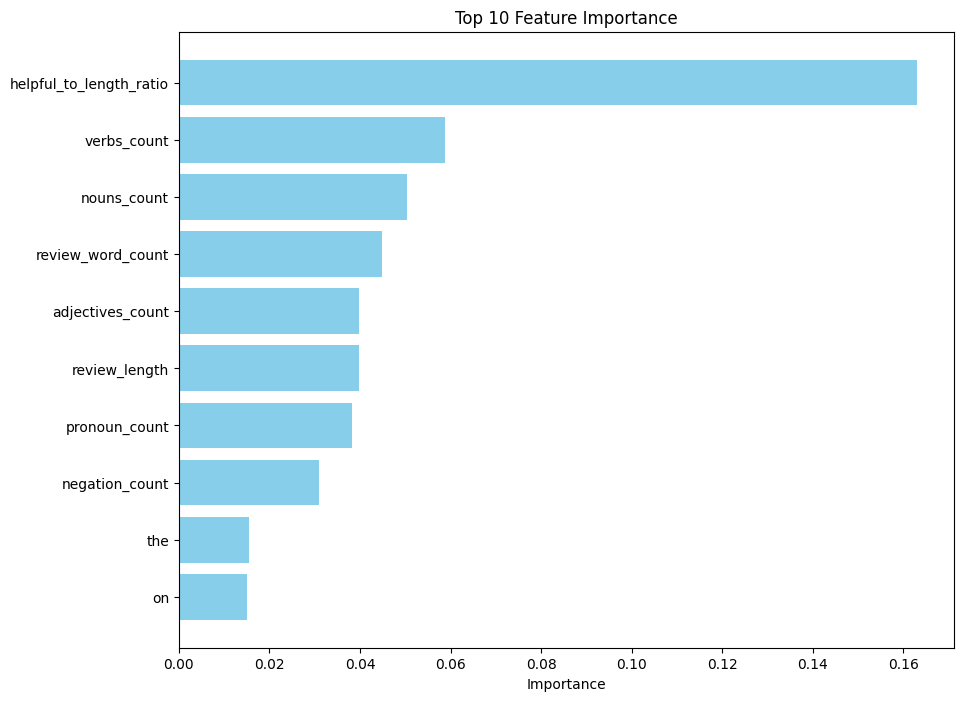

In [36]:
import matplotlib.pyplot as plt

# Select the top 10 features by importance
top_features = feature_importance_df.nlargest(10, 'importance')

# Plotting feature importance
plt.figure(figsize=(10, 8))
plt.barh(top_features['feature'], top_features['importance'], color='skyblue')
plt.xlabel('Importance')
plt.title('Top 10 Feature Importance')
plt.gca().invert_yaxis()  # To display the most important feature on top
plt.show()
